In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from PIL import Image
import glob
import os
from sklearn.model_selection import train_test_split
from math import log, exp
from time import time
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from copy import deepcopy

In [13]:
class Booster:
    def __init__(self, n_estimators=50, learning_rate=1, random_state=None, base_learner=DecisionTreeClassifier(max_depth=2)):
        self.n_estimators_ = n_estimators
        self.learning_rate_ = learning_rate
        self.random_state_ = random_state
        self.estimators_ = []
        self.alphas_ = np.zeros(self.n_estimators_)
        self.accuracies = None
        self.base_learner_ = base_learner
    
    def plot(self):
        if not self.accuracies:
            raise ValueError("ERROR: self.accuracies not defined. Make sure self.fit() is called with visible=True")
        plt.plot([i+1 for i in range(self.n_estimators_)],self.accuracies)
        plt.xlabel("Number of estimators")
        plt.ylabel("Accuracy")
        plt.show()

    def fit(self, X, Y, verbose=False, visible=False, verbose_visibility=False):
        if visible:
            self.accuracies = []
            
        self.n_samples_ = X.shape[0]
        self.classes_ = np.array(sorted(list(set(Y))))
        self.n_classes_ = len(self.classes_)
        for i in range(self.n_estimators_):
            if i == 0:
                if verbose:
                    print(f"Iteration starting after {time()-start:.2f} seconds")
                local_alphas = np.ones(self.n_samples_) / self.n_samples_
            local_weights, estimator_alpha, estimator_error = self.boost(X, Y, local_alphas, visible)
            
            if estimator_error is None:
                break
            
            self.alphas_[i] = estimator_alpha
            
            if verbose and (i+1) % verbose == 0:
                print(f"Iteration {i+1} ended after {time()-start:.2f} seconds")
            
            if visible:
                acc_start = time()
                self.accuracies.append(self.accuracy(self.predict(X),Y))
                if verbose_visibility and (i+1) % verbose_visibility == 0:
                    print(f"Accuracy {i+1} ({self.accuracies[-1]:.2%}) took {time()-acc_start:.2f} seconds")
                
            if estimator_error <= 0:
                break
        
        if visible:
            self.plot()
        
        return self
    
    def boost(self, X, Y, weights, visible):
        estimator = deepcopy(self.base_learner_)
        if self.random_state_:
            estimator.set_params(random_state=1)

        estimator.fit(X, Y, sample_weight=weights)

        y_hat = estimator.predict(X)
        incorrect = y_hat != Y
        estimator_error = np.dot(incorrect, weights) / np.sum(weights, axis=0)

        if estimator_error >= 1 - 1 / self.n_classes_:
            return None, None, None

        estimator_weight = self.learning_rate_ * np.log((1 - estimator_error) / estimator_error) + np.log(self.n_classes_ - 1)

        if estimator_weight <= 0:
            return None, None, None

        weights *= np.exp(estimator_weight * incorrect)

        w_sum = np.sum(weights, axis=0)
        if w_sum <= 0:
            return None, None, None

        weights /= w_sum

        self.estimators_.append(estimator)

        return np.array(weights), estimator_weight, estimator_error

    def predict(self, X):
        n_classes = self.n_classes_
        classes = self.classes_[:, np.newaxis]
        pred = sum((estimator.predict(X) == classes).T * a for estimator, a in zip(self.estimators_, self.alphas_))
        pred /= self.alphas_.sum()
        if n_classes == 2:
            pred[:, 0] *= -1
            pred = pred.sum(axis=1)
            return self.classes_.take(pred > 0, axis=0)
        
        return self.classes_.take(np.argmax(pred, axis=1), axis=0)
    
    def accuracy(self, y_hat, y_true):
        ones = np.where(y_hat == y_true, 1, 0)
        solid = np.ones((1,len(y_hat)))
        return ((ones @ ones.T) / (solid @ solid.T))[0][0]
    

In [2]:
import tensorflow as tf
import keras
from keras.datasets import mnist, fashion_mnist

In [3]:
(Xtrain,Ytrain), (Xtest,Ytest) = mnist.load_data()
Xtrain = Xtrain.astype("float32") / 255.
Xtest = Xtest.astype("float32") / 255.
Xtrain = Xtrain.reshape((len(Xtrain), np.prod(Xtrain.shape[1:])))
Xtest = Xtest.reshape((len(Xtest), np.prod(Xtest.shape[1:])))
print(Xtrain.shape)
print(Ytrain.shape)

(60000, 784)
(60000,)


Iteration starting after 0.01 seconds
Iteration 25 ended after 79.81 seconds
Accuracy 25 (70.24%) took 1.44 seconds
Iteration 50 ended after 199.25 seconds
Accuracy 50 (78.09%) took 2.75 seconds
Iteration 75 ended after 359.33 seconds
Accuracy 75 (79.96%) took 4.23 seconds
Iteration 100 ended after 545.52 seconds
Accuracy 100 (81.08%) took 6.58 seconds
Iteration 125 ended after 767.08 seconds
Accuracy 125 (83.66%) took 6.97 seconds
Iteration 150 ended after 1021.91 seconds
Accuracy 150 (83.78%) took 8.15 seconds
Iteration 175 ended after 1310.11 seconds
Accuracy 175 (84.29%) took 10.71 seconds
Iteration 200 ended after 1657.65 seconds
Accuracy 200 (85.00%) took 14.22 seconds
Iteration 225 ended after 2105.37 seconds
Accuracy 225 (84.58%) took 15.36 seconds
Iteration 250 ended after 2547.21 seconds
Accuracy 250 (85.51%) took 14.45 seconds
Iteration 275 ended after 2976.63 seconds
Accuracy 275 (85.36%) took 15.01 seconds
Iteration 300 ended after 3463.16 seconds
Accuracy 300 (85.35%) too

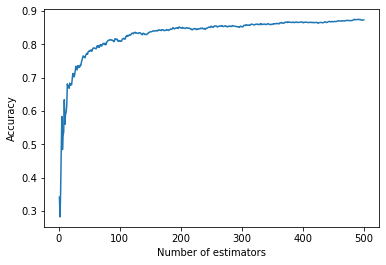

Accuracy: 87.35% over 500 trees after 8639.75 seconds


In [17]:
start = time()
n_estimators=500
booster = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=2)).fit(Xtrain, Ytrain, verbose=25, visible=True, verbose_visibility=25)
y_hat = booster.predict(Xtrain)
print(f"Accuracy: {booster.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees after {time()-start:.2f} seconds")

Iteration starting after 0.01 seconds
Iteration 25 ended after 50.87 seconds
Accuracy 25 (47.40%) took 1.38 seconds
Iteration 50 ended after 134.11 seconds
Accuracy 50 (57.53%) took 2.59 seconds
Iteration 75 ended after 249.32 seconds
Accuracy 75 (67.15%) took 3.86 seconds
Iteration 100 ended after 396.46 seconds
Accuracy 100 (70.12%) took 5.21 seconds
Iteration 125 ended after 576.07 seconds
Accuracy 125 (71.73%) took 6.40 seconds
Iteration 150 ended after 787.01 seconds
Accuracy 150 (73.47%) took 7.61 seconds
Iteration 175 ended after 1030.94 seconds
Accuracy 175 (74.01%) took 8.93 seconds
Iteration 200 ended after 1307.05 seconds
Accuracy 200 (75.35%) took 10.47 seconds
Iteration 225 ended after 1614.59 seconds
Accuracy 225 (76.25%) took 11.34 seconds
Iteration 250 ended after 1952.67 seconds
Accuracy 250 (76.39%) took 13.47 seconds
Iteration 275 ended after 2325.49 seconds
Accuracy 275 (76.10%) took 13.86 seconds
Iteration 300 ended after 2737.52 seconds
Accuracy 300 (77.00%) took 

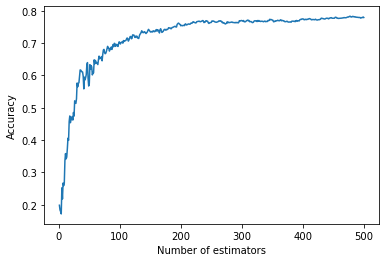

Accuracy: 77.91% over 500 trees after 7182.45 seconds


In [18]:
start = time()
n_estimators=500
booster = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=1)).fit(Xtrain, Ytrain, verbose=25, visible=True, verbose_visibility=25)
y_hat = booster.predict(Xtrain)
print(f"Accuracy: {booster.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees after {time()-start:.2f} seconds")

Iteration starting after 0.01 seconds
Iteration 25 ended after 105.61 seconds
Accuracy 25 (81.09%) took 1.46 seconds
Iteration 50 ended after 246.35 seconds
Accuracy 50 (85.25%) took 2.71 seconds
Iteration 75 ended after 420.19 seconds
Accuracy 75 (86.91%) took 4.03 seconds
Iteration 100 ended after 628.58 seconds
Accuracy 100 (88.26%) took 5.40 seconds
Iteration 125 ended after 871.81 seconds
Accuracy 125 (89.08%) took 6.70 seconds
Iteration 150 ended after 1154.77 seconds
Accuracy 150 (89.92%) took 9.92 seconds
Iteration 175 ended after 1482.82 seconds
Accuracy 175 (90.17%) took 10.16 seconds
Iteration 200 ended after 1825.78 seconds
Accuracy 200 (90.33%) took 10.69 seconds
Iteration 225 ended after 2202.25 seconds
Accuracy 225 (90.86%) took 12.99 seconds
Iteration 250 ended after 2621.10 seconds
Accuracy 250 (91.05%) took 14.08 seconds
Iteration 275 ended after 3068.25 seconds
Accuracy 275 (91.22%) took 14.77 seconds
Iteration 300 ended after 3547.13 seconds
Accuracy 300 (91.69%) to

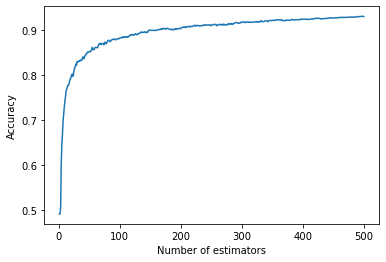

Accuracy: 93.00% over 500 trees after 8659.01 seconds


In [19]:
start = time()
n_estimators=500
booster = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=3)).fit(Xtrain, Ytrain, verbose=25, visible=True, verbose_visibility=25)
y_hat = booster.predict(Xtrain)
print(f"Accuracy: {booster.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees after {time()-start:.2f} seconds")

Iteration starting after 0.01 seconds
Iteration 25 ended after 225.93 seconds
Accuracy 25 (89.31%) took 1.74 seconds
Iteration 50 ended after 467.26 seconds
Accuracy 50 (92.51%) took 3.51 seconds
Iteration 75 ended after 755.50 seconds
Accuracy 75 (93.73%) took 5.30 seconds
Iteration 100 ended after 1087.86 seconds
Accuracy 100 (94.98%) took 7.08 seconds
Iteration 125 ended after 1473.10 seconds
Accuracy 125 (95.61%) took 11.05 seconds
Iteration 150 ended after 1944.10 seconds
Accuracy 150 (96.01%) took 10.81 seconds
Iteration 175 ended after 2432.07 seconds
Accuracy 175 (96.43%) took 13.53 seconds
Iteration 200 ended after 3069.64 seconds
Accuracy 200 (96.61%) took 34.26 seconds
Iteration 225 ended after 4253.54 seconds
Accuracy 225 (96.87%) took 35.92 seconds
Iteration 250 ended after 5487.50 seconds
Accuracy 250 (97.04%) took 40.94 seconds
Iteration 275 ended after 6621.53 seconds
Accuracy 275 (96.99%) took 24.94 seconds
Iteration 300 ended after 7292.10 seconds
Accuracy 300 (97.10%

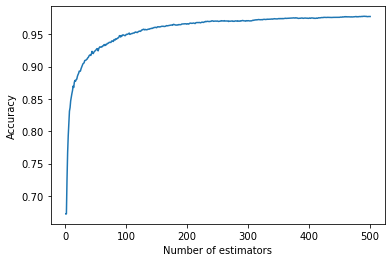

Accuracy: 97.74% over 500 trees after 13048.22 seconds


In [23]:
start = time()
n_estimators=500
booster = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=5)).fit(Xtrain, Ytrain, verbose=25, visible=True, verbose_visibility=25)
y_hat = booster.predict(Xtrain)
print(f"Accuracy: {booster.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees after {time()-start:.2f} seconds")

In [33]:
start = time()
n_estimators=500
booster1 = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=1)).fit(Xtrain, Ytrain, verbose=25)
y_hat = booster1.predict(Xtrain)
print(f"Train accuracy: {booster1.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster1.accuracy(booster1.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Iteration starting after 0.01 seconds
Iteration 25 ended after 51.83 seconds
Iteration 50 ended after 108.99 seconds
Iteration 75 ended after 168.12 seconds
Iteration 100 ended after 218.75 seconds
Iteration 125 ended after 260.70 seconds
Iteration 150 ended after 303.20 seconds
Iteration 175 ended after 346.64 seconds
Iteration 200 ended after 389.66 seconds
Iteration 225 ended after 431.59 seconds
Iteration 250 ended after 482.17 seconds
Iteration 275 ended after 526.35 seconds
Iteration 300 ended after 569.09 seconds
Iteration 325 ended after 611.66 seconds
Iteration 350 ended after 654.29 seconds
Iteration 375 ended after 696.87 seconds
Iteration 400 ended after 738.72 seconds
Iteration 425 ended after 781.83 seconds
Iteration 450 ended after 824.69 seconds
Iteration 475 ended after 866.41 seconds
Iteration 500 ended after 909.40 seconds
Train accuracy: 77.91% over 500 trees
Test accuracy: 78.36% over 500 trees


In [28]:
start = time()
n_estimators=500
booster2 = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=2)).fit(Xtrain, Ytrain, verbose=25)
y_hat = booster2.predict(Xtrain)
print(f"Train accuracy: {booster2.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster2.accuracy(booster2.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Iteration starting after 0.01 seconds
Iteration 25 ended after 85.01 seconds
Iteration 50 ended after 167.29 seconds
Iteration 75 ended after 236.82 seconds
Iteration 100 ended after 302.96 seconds
Iteration 125 ended after 369.71 seconds
Iteration 150 ended after 431.25 seconds
Iteration 175 ended after 493.29 seconds
Iteration 200 ended after 554.72 seconds
Iteration 225 ended after 616.57 seconds
Iteration 250 ended after 677.76 seconds
Iteration 275 ended after 739.39 seconds
Iteration 300 ended after 800.79 seconds
Iteration 325 ended after 862.36 seconds
Iteration 350 ended after 923.99 seconds
Iteration 375 ended after 986.47 seconds
Iteration 400 ended after 1047.93 seconds
Iteration 425 ended after 1109.20 seconds
Iteration 450 ended after 1172.35 seconds
Iteration 475 ended after 1233.94 seconds
Iteration 500 ended after 1295.65 seconds
Train accuracy: 87.35% over 500 trees
Test accuracy: 87.16% over 500 trees


In [31]:
start = time()
n_estimators=500
booster3 = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=3)).fit(Xtrain, Ytrain, verbose=25)
y_hat = booster3.predict(Xtrain)
print(f"Train accuracy: {booster3.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster3.accuracy(booster3.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Iteration starting after 0.01 seconds
Iteration 25 ended after 89.72 seconds
Iteration 50 ended after 178.37 seconds
Iteration 75 ended after 267.90 seconds
Iteration 100 ended after 356.75 seconds
Iteration 125 ended after 446.39 seconds
Iteration 150 ended after 535.00 seconds
Iteration 175 ended after 624.06 seconds
Iteration 200 ended after 713.40 seconds
Iteration 225 ended after 802.30 seconds
Iteration 250 ended after 893.66 seconds
Iteration 275 ended after 982.03 seconds
Iteration 300 ended after 1071.53 seconds
Iteration 325 ended after 1160.19 seconds
Iteration 350 ended after 1249.37 seconds
Iteration 375 ended after 1337.88 seconds
Iteration 400 ended after 1427.24 seconds
Iteration 425 ended after 1515.69 seconds
Iteration 450 ended after 1605.66 seconds
Iteration 475 ended after 1693.79 seconds
Iteration 500 ended after 1783.34 seconds
Train accuracy: 93.00% over 500 trees
Test accuracy: 92.00% over 500 trees


In [30]:
start = time()
n_estimators=500
booster5 = Booster(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=5)).fit(Xtrain, Ytrain, verbose=25)
y_hat = booster5.predict(Xtrain)
print(f"Train accuracy: {booster5.accuracy(y_hat, Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster5.accuracy(booster5.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Iteration starting after 0.01 seconds
Iteration 25 ended after 142.87 seconds
Iteration 50 ended after 285.34 seconds
Iteration 75 ended after 426.87 seconds
Iteration 100 ended after 569.19 seconds
Iteration 125 ended after 710.90 seconds
Iteration 150 ended after 853.19 seconds
Iteration 175 ended after 995.70 seconds
Iteration 200 ended after 1137.48 seconds
Iteration 225 ended after 1279.32 seconds
Iteration 250 ended after 1423.33 seconds
Iteration 275 ended after 1564.98 seconds
Iteration 300 ended after 1707.99 seconds
Iteration 325 ended after 1849.78 seconds
Iteration 350 ended after 1993.33 seconds
Iteration 375 ended after 2135.79 seconds
Iteration 400 ended after 2277.31 seconds
Iteration 425 ended after 2419.18 seconds
Iteration 450 ended after 2562.00 seconds
Iteration 475 ended after 2704.06 seconds
Iteration 500 ended after 2847.01 seconds
Train accuracy: 97.74% over 500 trees
Test accuracy: 95.54% over 500 trees


Accuracy 25 (47.78% in 0.06 seconds) after 40.17 seconds
Accuracy 50 (56.70% in 0.07 seconds) after 74.75 seconds
Accuracy 75 (66.22% in 0.06 seconds) after 110.12 seconds
Accuracy 100 (69.93% in 0.06 seconds) after 145.31 seconds
Accuracy 125 (71.45% in 0.05 seconds) after 179.68 seconds
Accuracy 150 (73.60% in 0.07 seconds) after 216.85 seconds
Accuracy 175 (74.00% in 0.07 seconds) after 251.01 seconds
Accuracy 200 (75.38% in 0.07 seconds) after 286.24 seconds
Accuracy 225 (76.14% in 0.06 seconds) after 322.06 seconds
Accuracy 250 (76.42% in 0.05 seconds) after 359.99 seconds
Accuracy 275 (76.03% in 0.09 seconds) after 402.74 seconds
Accuracy 300 (77.06% in 0.09 seconds) after 447.06 seconds
Accuracy 325 (76.72% in 0.09 seconds) after 489.96 seconds
Accuracy 350 (77.03% in 0.07 seconds) after 534.53 seconds
Accuracy 375 (76.63% in 0.08 seconds) after 578.98 seconds
Accuracy 400 (77.46% in 0.10 seconds) after 622.71 seconds
Accuracy 425 (77.14% in 0.09 seconds) after 666.80 seconds
Ac

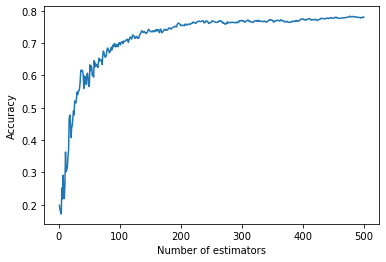

In [4]:
from functions import *
start = time()
n_estimators = 500
booster_update = Boost(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=1)).update_fit(Xtrain,Ytrain, verbose=25)

In [7]:
print(f"Train accuracy: {booster_update.accuracy(booster_update.predict(Xtrain), Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster_update.accuracy(booster_update.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Train accuracy: 77.91% over 500 trees
Test accuracy: 78.36% over 500 trees


Accuracy 25 (71.01% in 0.08 seconds) after 92.53 seconds
Accuracy 50 (78.25% in 0.10 seconds) after 169.92 seconds
Accuracy 75 (80.19% in 0.09 seconds) after 257.05 seconds
Accuracy 100 (81.20% in 0.07 seconds) after 322.55 seconds
Accuracy 125 (83.78% in 0.09 seconds) after 384.65 seconds
Accuracy 150 (83.75% in 0.07 seconds) after 447.53 seconds
Accuracy 175 (84.33% in 0.06 seconds) after 512.29 seconds
Accuracy 200 (85.05% in 0.14 seconds) after 582.19 seconds
Accuracy 225 (84.66% in 0.06 seconds) after 652.51 seconds
Accuracy 250 (85.52% in 0.07 seconds) after 716.00 seconds
Accuracy 275 (85.43% in 0.06 seconds) after 778.78 seconds
Accuracy 300 (85.56% in 0.07 seconds) after 841.03 seconds
Accuracy 325 (86.11% in 0.06 seconds) after 903.47 seconds
Accuracy 350 (86.19% in 0.06 seconds) after 965.69 seconds
Accuracy 375 (86.70% in 0.06 seconds) after 1029.33 seconds
Accuracy 400 (86.64% in 0.06 seconds) after 1091.72 seconds
Accuracy 425 (86.44% in 0.08 seconds) after 1154.28 second

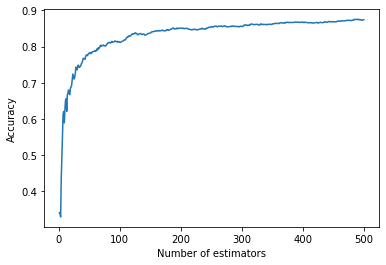

Train accuracy: 87.35% over 500 trees
Test accuracy: 87.16% over 500 trees


In [8]:
booster_update2 = Boost(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=2)).update_fit(Xtrain,Ytrain, verbose=25)
print(f"Train accuracy: {booster_update2.accuracy(booster_update2.predict(Xtrain), Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster_update2.accuracy(booster_update2.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Accuracy 25 (75.25% in 0.07 seconds) after 99.63 seconds
Accuracy 50 (82.09% in 0.06 seconds) after 191.90 seconds
Accuracy 75 (85.39% in 0.07 seconds) after 282.13 seconds
Accuracy 100 (86.69% in 0.06 seconds) after 372.78 seconds
Accuracy 125 (87.77% in 0.06 seconds) after 461.76 seconds
Accuracy 150 (88.83% in 0.06 seconds) after 551.44 seconds
Accuracy 175 (89.21% in 0.09 seconds) after 640.24 seconds
Accuracy 200 (89.92% in 0.06 seconds) after 729.45 seconds
Accuracy 225 (90.32% in 0.07 seconds) after 817.64 seconds
Accuracy 250 (90.85% in 0.08 seconds) after 907.29 seconds
Accuracy 275 (91.22% in 0.06 seconds) after 995.93 seconds
Accuracy 300 (91.47% in 0.08 seconds) after 1085.13 seconds
Accuracy 325 (91.69% in 0.08 seconds) after 1173.44 seconds
Accuracy 350 (91.98% in 0.06 seconds) after 1262.89 seconds
Accuracy 375 (92.06% in 0.06 seconds) after 1351.68 seconds
Accuracy 400 (92.26% in 0.08 seconds) after 1441.22 seconds
Accuracy 425 (92.44% in 0.06 seconds) after 1529.63 sec

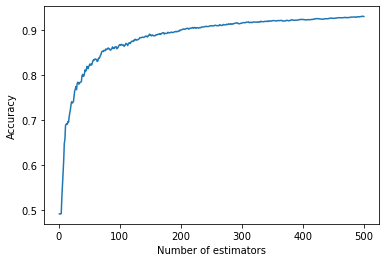

Train accuracy: 93.00% over 500 trees
Test accuracy: 92.00% over 500 trees


In [9]:
booster_update3 = Boost(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=3)).update_fit(Xtrain,Ytrain, verbose=25)
print(f"Train accuracy: {booster_update3.accuracy(booster_update3.predict(Xtrain), Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster_update3.accuracy(booster_update3.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Accuracy 25 (83.28% in 0.07 seconds) after 140.75 seconds
Accuracy 50 (89.63% in 0.06 seconds) after 282.26 seconds
Accuracy 75 (92.12% in 0.06 seconds) after 423.01 seconds
Accuracy 100 (93.74% in 0.09 seconds) after 564.16 seconds
Accuracy 125 (94.73% in 0.06 seconds) after 704.97 seconds
Accuracy 150 (95.32% in 0.06 seconds) after 846.16 seconds
Accuracy 175 (95.88% in 0.06 seconds) after 987.29 seconds
Accuracy 200 (96.19% in 0.08 seconds) after 1130.72 seconds
Accuracy 225 (96.46% in 0.07 seconds) after 1279.78 seconds
Accuracy 250 (96.67% in 0.07 seconds) after 1420.86 seconds
Accuracy 275 (96.78% in 0.07 seconds) after 1561.66 seconds
Accuracy 300 (96.87% in 0.09 seconds) after 1703.09 seconds
Accuracy 325 (97.06% in 0.08 seconds) after 1844.82 seconds
Accuracy 350 (97.24% in 0.07 seconds) after 1985.68 seconds
Accuracy 375 (97.35% in 0.08 seconds) after 2127.36 seconds
Accuracy 400 (97.32% in 0.08 seconds) after 2268.08 seconds
Accuracy 425 (97.42% in 0.08 seconds) after 2408.7

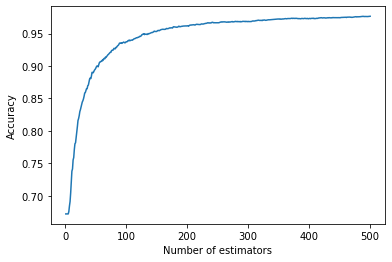

Train accuracy: 97.74% over 500 trees
Test accuracy: 95.54% over 500 trees


In [10]:
booster_update5 = Boost(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=5)).update_fit(Xtrain,Ytrain, verbose=25)
print(f"Train accuracy: {booster_update5.accuracy(booster_update5.predict(Xtrain), Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster_update5.accuracy(booster_update5.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Accuracy/Loss 1 (34.18%/1005.064 in 0.48 seconds) after 4.70 seconds
Accuracy/Loss 2 (34.18%/1003.903 in 0.47 seconds) after 10.33 seconds
Accuracy/Loss 3 (32.98%/1004.645 in 0.46 seconds) after 14.82 seconds
Accuracy/Loss 4 (43.59%/1003.494 in 0.49 seconds) after 19.38 seconds
Accuracy/Loss 5 (49.02%/1003.401 in 0.52 seconds) after 23.96 seconds
Accuracy/Loss 6 (55.19%/1001.650 in 0.50 seconds) after 28.54 seconds
Accuracy/Loss 7 (61.31%/1001.145 in 0.49 seconds) after 33.10 seconds
Accuracy/Loss 8 (62.07%/1002.204 in 0.51 seconds) after 37.65 seconds
Accuracy/Loss 9 (58.93%/1002.772 in 0.49 seconds) after 42.27 seconds
Accuracy/Loss 10 (62.59%/1002.167 in 0.50 seconds) after 46.90 seconds
Accuracy/Loss 11 (65.11%/1001.106 in 1.77 seconds) after 52.79 seconds
Accuracy/Loss 12 (65.59%/1001.099 in 0.50 seconds) after 57.42 seconds
Accuracy/Loss 13 (62.10%/1001.098 in 0.51 seconds) after 62.00 seconds
Accuracy/Loss 14 (66.70%/1001.670 in 0.51 seconds) after 66.63 seconds
Accuracy/Loss 15

Accuracy/Loss 116 (83.00%/1001.594 in 0.30 seconds) after 464.07 seconds
Accuracy/Loss 117 (82.92%/1001.594 in 0.30 seconds) after 466.77 seconds
Accuracy/Loss 118 (82.98%/1001.594 in 0.49 seconds) after 470.12 seconds
Accuracy/Loss 119 (83.25%/1001.593 in 0.30 seconds) after 472.93 seconds
Accuracy/Loss 120 (83.40%/1001.593 in 0.34 seconds) after 475.71 seconds
Accuracy/Loss 121 (83.52%/1001.593 in 0.28 seconds) after 478.39 seconds
Accuracy/Loss 122 (83.40%/1001.593 in 0.32 seconds) after 481.25 seconds
Accuracy/Loss 123 (83.47%/1001.593 in 0.30 seconds) after 483.97 seconds
Accuracy/Loss 124 (83.55%/1001.593 in 0.29 seconds) after 486.66 seconds
Accuracy/Loss 125 (83.78%/1001.593 in 0.32 seconds) after 489.64 seconds
Accuracy/Loss 126 (83.58%/1001.593 in 0.31 seconds) after 492.40 seconds
Accuracy/Loss 127 (83.64%/1001.593 in 0.33 seconds) after 495.14 seconds
Accuracy/Loss 128 (83.57%/1001.593 in 0.30 seconds) after 497.85 seconds
Accuracy/Loss 129 (83.25%/1001.593 in 0.30 seconds)

Accuracy/Loss 229 (84.68%/1001.028 in 0.32 seconds) after 776.04 seconds
Accuracy/Loss 230 (84.76%/1001.028 in 0.33 seconds) after 778.76 seconds
Accuracy/Loss 231 (84.81%/1001.028 in 0.32 seconds) after 781.66 seconds
Accuracy/Loss 232 (84.84%/1001.028 in 0.33 seconds) after 784.39 seconds
Accuracy/Loss 233 (84.78%/1001.028 in 0.30 seconds) after 787.09 seconds
Accuracy/Loss 234 (84.96%/1001.587 in 0.31 seconds) after 790.01 seconds
Accuracy/Loss 235 (85.07%/1001.027 in 0.31 seconds) after 792.67 seconds
Accuracy/Loss 236 (84.88%/1001.027 in 0.32 seconds) after 795.39 seconds
Accuracy/Loss 237 (84.81%/1001.027 in 0.32 seconds) after 798.13 seconds
Accuracy/Loss 238 (84.85%/1001.027 in 0.33 seconds) after 800.85 seconds
Accuracy/Loss 239 (84.89%/1001.027 in 0.29 seconds) after 803.54 seconds
Accuracy/Loss 240 (84.76%/1001.027 in 0.32 seconds) after 806.26 seconds
Accuracy/Loss 241 (84.82%/1001.027 in 0.32 seconds) after 808.96 seconds
Accuracy/Loss 242 (85.05%/1001.027 in 0.31 seconds)

Accuracy/Loss 341 (85.96%/1001.025 in 0.35 seconds) after 1082.34 seconds
Accuracy/Loss 342 (86.10%/1001.025 in 0.33 seconds) after 1085.24 seconds
Accuracy/Loss 343 (86.12%/1001.025 in 0.33 seconds) after 1088.02 seconds
Accuracy/Loss 344 (86.08%/1001.025 in 0.30 seconds) after 1090.80 seconds
Accuracy/Loss 345 (86.14%/1001.025 in 0.37 seconds) after 1093.59 seconds
Accuracy/Loss 346 (86.11%/1001.025 in 0.31 seconds) after 1096.53 seconds
Accuracy/Loss 347 (86.14%/1001.025 in 0.34 seconds) after 1099.28 seconds
Accuracy/Loss 348 (86.10%/1001.025 in 0.30 seconds) after 1101.97 seconds
Accuracy/Loss 349 (86.06%/1001.025 in 0.27 seconds) after 1104.63 seconds
Accuracy/Loss 350 (86.19%/1001.025 in 0.30 seconds) after 1107.31 seconds
Accuracy/Loss 351 (86.29%/1001.025 in 0.33 seconds) after 1110.01 seconds
Accuracy/Loss 352 (86.22%/1001.025 in 0.29 seconds) after 1112.69 seconds
Accuracy/Loss 353 (86.34%/1001.025 in 0.29 seconds) after 1115.36 seconds
Accuracy/Loss 354 (86.31%/1001.025 in 

Accuracy/Loss 452 (86.86%/1001.582 in 0.29 seconds) after 1385.77 seconds
Accuracy/Loss 453 (86.78%/1001.582 in 0.36 seconds) after 1388.67 seconds
Accuracy/Loss 454 (86.83%/1001.582 in 0.33 seconds) after 1391.42 seconds
Accuracy/Loss 455 (86.82%/1001.582 in 0.31 seconds) after 1394.13 seconds
Accuracy/Loss 456 (86.94%/1001.582 in 0.29 seconds) after 1396.78 seconds
Accuracy/Loss 457 (86.97%/1001.582 in 0.30 seconds) after 1399.51 seconds
Accuracy/Loss 458 (87.03%/1001.582 in 0.33 seconds) after 1402.24 seconds
Accuracy/Loss 459 (87.01%/1001.582 in 0.33 seconds) after 1404.95 seconds
Accuracy/Loss 460 (87.03%/1001.582 in 0.36 seconds) after 1407.72 seconds
Accuracy/Loss 461 (86.95%/1001.582 in 0.30 seconds) after 1410.39 seconds
Accuracy/Loss 462 (87.01%/1001.582 in 0.31 seconds) after 1413.07 seconds
Accuracy/Loss 463 (87.01%/1001.582 in 0.34 seconds) after 1415.78 seconds
Accuracy/Loss 464 (87.11%/1001.582 in 0.31 seconds) after 1418.48 seconds
Accuracy/Loss 465 (87.10%/1001.582 in 

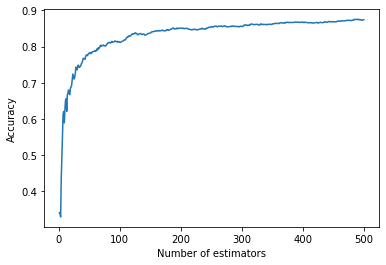

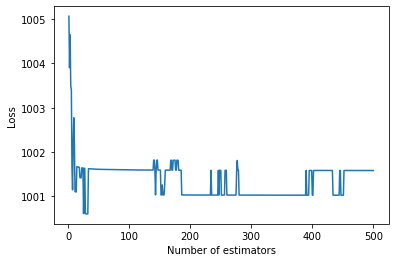

Train accuracy: 87.35% over 500 trees
Test accuracy: 87.16% over 500 trees


In [4]:
from functions import *
n_estimators = 500
booster_update2 = Boost(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=2)).update_fit(Xtrain,Ytrain, verbose=1)
print(f"Train accuracy: {booster_update2.accuracy(booster_update2.predict(Xtrain), Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster_update2.accuracy(booster_update2.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Accuracy/Loss 1 (34.50%/1004.785 in 0.33 seconds) after 0.71 seconds
Accuracy/Loss 2 (34.50%/1003.620 in 0.50 seconds) after 1.51 seconds
Accuracy/Loss 3 (37.31%/1003.363 in 0.29 seconds) after 2.09 seconds
Accuracy/Loss 4 (45.99%/1002.733 in 0.27 seconds) after 2.64 seconds
Accuracy/Loss 5 (54.36%/1002.040 in 0.29 seconds) after 3.21 seconds
Accuracy/Loss 6 (59.31%/1001.162 in 0.30 seconds) after 3.78 seconds
Accuracy/Loss 7 (58.64%/1001.154 in 0.30 seconds) after 4.36 seconds
Accuracy/Loss 8 (58.05%/1001.974 in 0.29 seconds) after 4.92 seconds
Accuracy/Loss 9 (59.66%/1001.127 in 0.31 seconds) after 5.49 seconds
Accuracy/Loss 10 (60.04%/1002.052 in 0.33 seconds) after 6.08 seconds
Accuracy/Loss 11 (62.60%/1000.053 in 0.31 seconds) after 6.65 seconds
Accuracy/Loss 12 (62.04%/1001.453 in 0.31 seconds) after 7.24 seconds
Accuracy/Loss 13 (63.54%/1001.447 in 0.29 seconds) after 7.80 seconds
Accuracy/Loss 14 (65.17%/1002.492 in 0.27 seconds) after 8.35 seconds
Accuracy/Loss 15 (65.67%/1002

Accuracy/Loss 115 (77.02%/1001.038 in 0.31 seconds) after 72.98 seconds
Accuracy/Loss 116 (77.15%/1001.038 in 0.32 seconds) after 73.58 seconds
Accuracy/Loss 117 (77.32%/1001.038 in 0.33 seconds) after 74.18 seconds
Accuracy/Loss 118 (77.31%/1001.038 in 0.32 seconds) after 74.79 seconds
Accuracy/Loss 119 (77.37%/1001.038 in 0.33 seconds) after 75.40 seconds
Accuracy/Loss 120 (77.55%/1001.038 in 0.31 seconds) after 75.99 seconds
Accuracy/Loss 121 (77.33%/1001.038 in 0.34 seconds) after 76.61 seconds
Accuracy/Loss 122 (77.78%/1001.038 in 0.36 seconds) after 77.58 seconds
Accuracy/Loss 123 (77.66%/1001.038 in 0.31 seconds) after 78.17 seconds
Accuracy/Loss 124 (77.28%/1001.038 in 0.33 seconds) after 78.78 seconds
Accuracy/Loss 125 (76.86%/1001.038 in 0.33 seconds) after 79.41 seconds
Accuracy/Loss 126 (77.55%/1001.038 in 0.31 seconds) after 80.01 seconds
Accuracy/Loss 127 (77.59%/1001.038 in 0.32 seconds) after 80.61 seconds
Accuracy/Loss 128 (77.60%/1001.038 in 0.34 seconds) after 81.25 

Accuracy/Loss 224 (82.02%/1001.033 in 0.33 seconds) after 142.28 seconds
Accuracy/Loss 225 (81.94%/1001.033 in 0.32 seconds) after 142.88 seconds
Accuracy/Loss 226 (82.02%/1001.033 in 0.35 seconds) after 143.51 seconds
Accuracy/Loss 227 (82.16%/1001.033 in 0.31 seconds) after 144.11 seconds
Accuracy/Loss 228 (82.06%/1001.033 in 0.35 seconds) after 144.76 seconds
Accuracy/Loss 229 (81.88%/1001.032 in 0.37 seconds) after 145.42 seconds
Accuracy/Loss 230 (81.86%/1001.032 in 0.38 seconds) after 146.10 seconds
Accuracy/Loss 231 (81.95%/1001.032 in 0.35 seconds) after 146.78 seconds
Accuracy/Loss 232 (82.05%/1001.032 in 0.32 seconds) after 147.40 seconds
Accuracy/Loss 233 (82.02%/1001.032 in 0.36 seconds) after 148.04 seconds
Accuracy/Loss 234 (82.13%/1001.032 in 0.43 seconds) after 148.82 seconds
Accuracy/Loss 235 (82.09%/1001.032 in 0.37 seconds) after 149.60 seconds
Accuracy/Loss 236 (82.14%/1001.032 in 0.37 seconds) after 150.26 seconds
Accuracy/Loss 237 (82.13%/1001.032 in 0.33 seconds)

Accuracy/Loss 334 (82.17%/1001.030 in 0.66 seconds) after 218.88 seconds
Accuracy/Loss 335 (82.12%/1001.030 in 0.39 seconds) after 220.11 seconds
Accuracy/Loss 336 (82.03%/1001.030 in 0.44 seconds) after 220.89 seconds
Accuracy/Loss 337 (82.16%/1001.030 in 0.46 seconds) after 221.68 seconds
Accuracy/Loss 338 (81.94%/1001.030 in 0.39 seconds) after 222.47 seconds
Accuracy/Loss 339 (81.89%/1001.030 in 0.37 seconds) after 223.17 seconds
Accuracy/Loss 340 (82.08%/1001.030 in 0.35 seconds) after 223.81 seconds
Accuracy/Loss 341 (82.32%/1001.030 in 0.32 seconds) after 224.42 seconds
Accuracy/Loss 342 (82.30%/1001.030 in 0.35 seconds) after 225.06 seconds
Accuracy/Loss 343 (82.50%/1001.030 in 0.33 seconds) after 225.69 seconds
Accuracy/Loss 344 (82.42%/1001.030 in 0.33 seconds) after 226.31 seconds
Accuracy/Loss 345 (82.56%/1001.030 in 0.34 seconds) after 226.93 seconds
Accuracy/Loss 346 (82.46%/1001.030 in 0.36 seconds) after 227.59 seconds
Accuracy/Loss 347 (82.44%/1001.030 in 0.36 seconds)

Accuracy/Loss 440 (83.35%/1001.029 in 0.45 seconds) after 289.22 seconds
Accuracy/Loss 441 (83.35%/1001.029 in 0.62 seconds) after 290.21 seconds
Accuracy/Loss 442 (83.29%/1001.029 in 0.83 seconds) after 291.78 seconds
Accuracy/Loss 443 (83.40%/1001.029 in 0.47 seconds) after 292.89 seconds
Accuracy/Loss 444 (83.36%/1001.029 in 0.39 seconds) after 293.61 seconds
Accuracy/Loss 445 (83.41%/1001.029 in 0.58 seconds) after 294.74 seconds
Accuracy/Loss 446 (83.47%/1001.029 in 0.57 seconds) after 295.78 seconds
Accuracy/Loss 447 (83.54%/1001.029 in 0.56 seconds) after 296.79 seconds
Accuracy/Loss 448 (83.44%/1001.029 in 0.50 seconds) after 297.76 seconds
Accuracy/Loss 449 (83.50%/1001.029 in 0.47 seconds) after 298.61 seconds
Accuracy/Loss 450 (83.57%/1001.029 in 0.42 seconds) after 299.51 seconds
Accuracy/Loss 451 (83.58%/1001.029 in 0.44 seconds) after 300.31 seconds
Accuracy/Loss 452 (83.52%/1001.029 in 0.40 seconds) after 301.08 seconds
Accuracy/Loss 453 (83.55%/1001.029 in 0.44 seconds)

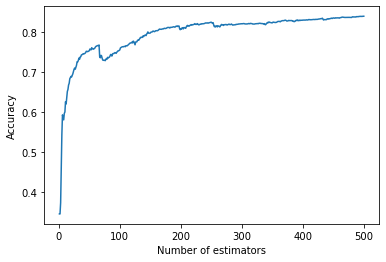

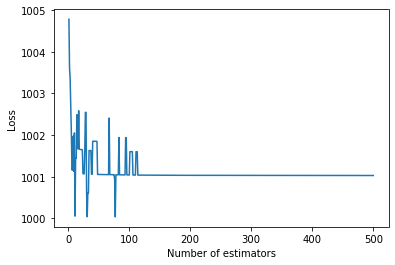

Train accuracy: 84.01% over 500 trees
Test accuracy: 84.43% over 500 trees


In [4]:
from functions import *
n_estimators = 500
booster_update2 = Boost(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=2)).update_fit(Xtrain,Ytrain, verbose=1, batch_size=6000)
print(f"Train accuracy: {booster_update2.accuracy(booster_update2.predict(Xtrain), Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster_update2.accuracy(booster_update2.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Accuracy/Loss 1 (33.00%/1003.761 in 0.35 seconds) after 0.47 seconds
Accuracy/Loss 2 (33.00%/1002.892 in 0.34 seconds) after 0.89 seconds
Accuracy/Loss 3 (36.10%/1002.655 in 0.36 seconds) after 1.32 seconds
Accuracy/Loss 4 (38.84%/1002.576 in 0.35 seconds) after 1.75 seconds
Accuracy/Loss 5 (34.40%/1003.010 in 0.39 seconds) after 2.22 seconds
Accuracy/Loss 6 (45.26%/1000.920 in 0.39 seconds) after 2.69 seconds
Accuracy/Loss 7 (46.91%/1001.973 in 0.60 seconds) after 3.41 seconds
Accuracy/Loss 8 (49.27%/1001.960 in 0.48 seconds) after 4.06 seconds
Accuracy/Loss 9 (53.91%/1002.412 in 0.35 seconds) after 4.49 seconds
Accuracy/Loss 10 (52.28%/1002.396 in 0.34 seconds) after 4.90 seconds
Accuracy/Loss 11 (54.66%/1002.382 in 0.34 seconds) after 5.32 seconds
Accuracy/Loss 12 (55.23%/1002.378 in 0.36 seconds) after 5.76 seconds
Accuracy/Loss 13 (57.86%/1001.326 in 0.36 seconds) after 6.20 seconds
Accuracy/Loss 14 (59.54%/1002.360 in 0.37 seconds) after 6.64 seconds
Accuracy/Loss 15 (60.15%/1001

Accuracy/Loss 108 (70.82%/1000.597 in 0.74 seconds) after 57.35 seconds
Accuracy/Loss 109 (71.03%/1000.597 in 0.80 seconds) after 58.32 seconds
Accuracy/Loss 110 (71.48%/1000.597 in 0.80 seconds) after 59.29 seconds
Accuracy/Loss 111 (72.31%/1000.596 in 0.70 seconds) after 60.17 seconds
Accuracy/Loss 112 (72.39%/1001.600 in 0.62 seconds) after 60.92 seconds
Accuracy/Loss 113 (72.50%/1001.600 in 0.50 seconds) after 61.54 seconds
Accuracy/Loss 114 (72.62%/1001.600 in 0.51 seconds) after 62.16 seconds
Accuracy/Loss 115 (72.54%/1001.600 in 0.61 seconds) after 62.88 seconds
Accuracy/Loss 116 (72.72%/1000.596 in 0.72 seconds) after 64.03 seconds
Accuracy/Loss 117 (72.90%/1001.600 in 0.46 seconds) after 64.60 seconds
Accuracy/Loss 118 (72.90%/1001.600 in 0.55 seconds) after 65.25 seconds
Accuracy/Loss 119 (73.13%/1001.600 in 0.73 seconds) after 66.14 seconds
Accuracy/Loss 120 (73.59%/1001.600 in 0.56 seconds) after 66.84 seconds
Accuracy/Loss 121 (73.59%/1001.599 in 0.47 seconds) after 67.45 

Accuracy/Loss 210 (78.12%/1001.036 in 0.52 seconds) after 119.73 seconds
Accuracy/Loss 211 (78.13%/1001.036 in 0.49 seconds) after 120.33 seconds
Accuracy/Loss 212 (78.22%/1001.036 in 0.44 seconds) after 120.87 seconds
Accuracy/Loss 213 (78.37%/1001.036 in 0.44 seconds) after 121.43 seconds
Accuracy/Loss 214 (78.27%/1001.036 in 0.44 seconds) after 121.97 seconds
Accuracy/Loss 215 (78.42%/1001.036 in 0.61 seconds) after 122.69 seconds
Accuracy/Loss 216 (78.57%/1001.036 in 0.69 seconds) after 123.59 seconds
Accuracy/Loss 217 (78.61%/1001.036 in 0.44 seconds) after 124.18 seconds
Accuracy/Loss 218 (78.72%/1001.035 in 0.45 seconds) after 124.73 seconds
Accuracy/Loss 219 (78.77%/1001.035 in 0.45 seconds) after 125.29 seconds
Accuracy/Loss 220 (78.78%/1001.035 in 0.43 seconds) after 125.83 seconds
Accuracy/Loss 221 (78.75%/1001.035 in 0.45 seconds) after 126.38 seconds
Accuracy/Loss 222 (78.86%/1001.035 in 0.45 seconds) after 126.95 seconds
Accuracy/Loss 223 (78.94%/1001.035 in 0.42 seconds)

Accuracy/Loss 312 (79.71%/1001.033 in 0.45 seconds) after 180.28 seconds
Accuracy/Loss 313 (79.80%/1001.033 in 0.46 seconds) after 180.84 seconds
Accuracy/Loss 314 (79.81%/1001.033 in 0.46 seconds) after 181.41 seconds
Accuracy/Loss 315 (79.81%/1001.033 in 0.46 seconds) after 181.98 seconds
Accuracy/Loss 316 (79.82%/1001.033 in 0.59 seconds) after 182.68 seconds
Accuracy/Loss 317 (79.88%/1001.033 in 0.68 seconds) after 183.57 seconds
Accuracy/Loss 318 (79.92%/1001.033 in 0.48 seconds) after 184.20 seconds
Accuracy/Loss 319 (79.94%/1001.033 in 0.44 seconds) after 184.76 seconds
Accuracy/Loss 320 (80.00%/1001.033 in 0.47 seconds) after 185.34 seconds
Accuracy/Loss 321 (80.02%/1001.033 in 0.45 seconds) after 185.90 seconds
Accuracy/Loss 322 (80.05%/1001.033 in 0.43 seconds) after 186.44 seconds
Accuracy/Loss 323 (80.03%/1001.033 in 0.46 seconds) after 187.02 seconds
Accuracy/Loss 324 (80.07%/1001.033 in 0.44 seconds) after 187.56 seconds
Accuracy/Loss 325 (80.10%/1001.033 in 0.47 seconds)

Accuracy/Loss 420 (80.82%/1001.032 in 0.47 seconds) after 244.06 seconds
Accuracy/Loss 421 (80.82%/1001.032 in 0.45 seconds) after 244.75 seconds
Accuracy/Loss 422 (80.73%/1001.032 in 0.45 seconds) after 245.31 seconds
Accuracy/Loss 423 (80.70%/1001.032 in 0.46 seconds) after 245.88 seconds
Accuracy/Loss 424 (80.76%/1001.032 in 0.49 seconds) after 246.48 seconds
Accuracy/Loss 425 (80.76%/1001.032 in 0.51 seconds) after 247.12 seconds
Accuracy/Loss 426 (80.74%/1001.032 in 0.48 seconds) after 247.70 seconds
Accuracy/Loss 427 (80.73%/1001.032 in 0.47 seconds) after 248.27 seconds
Accuracy/Loss 428 (80.79%/1001.032 in 0.45 seconds) after 248.82 seconds
Accuracy/Loss 429 (80.87%/1001.032 in 0.43 seconds) after 249.36 seconds
Accuracy/Loss 430 (80.86%/1001.032 in 0.46 seconds) after 249.93 seconds
Accuracy/Loss 431 (80.87%/1001.032 in 0.45 seconds) after 250.49 seconds
Accuracy/Loss 432 (80.87%/1001.032 in 0.47 seconds) after 251.08 seconds
Accuracy/Loss 433 (80.86%/1001.032 in 0.48 seconds)

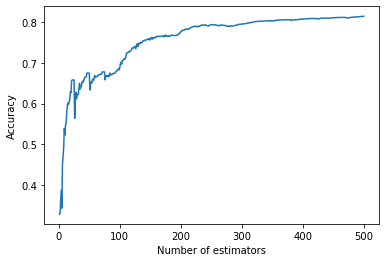

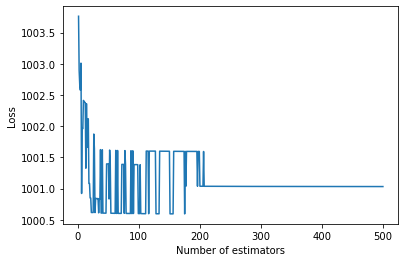

Train accuracy: 81.33% over 500 trees
Test accuracy: 81.77% over 500 trees


In [5]:
from functions import *
n_estimators = 500
booster_update2 = Boost(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=2)).update_fit(Xtrain,Ytrain, verbose=1, batch_size=600)
print(f"Train accuracy: {booster_update2.accuracy(booster_update2.predict(Xtrain), Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster_update2.accuracy(booster_update2.predict(Xtest),Ytest):.2%} over {n_estimators} trees")

Accuracy/Loss 1 (26.38%/1003.767 in 0.39 seconds) after 0.51 seconds
Accuracy/Loss 2 (26.38%/1003.376 in 0.38 seconds) after 0.96 seconds
Accuracy/Loss 3 (26.38%/1003.264 in 0.39 seconds) after 1.44 seconds
Accuracy/Loss 4 (30.64%/1002.177 in 0.40 seconds) after 1.91 seconds
Accuracy/Loss 5 (35.60%/1002.831 in 0.39 seconds) after 2.37 seconds
Accuracy/Loss 6 (35.60%/1002.826 in 0.42 seconds) after 2.87 seconds
Accuracy/Loss 7 (32.39%/1003.168 in 0.38 seconds) after 3.33 seconds
Accuracy/Loss 8 (37.41%/1002.928 in 0.37 seconds) after 3.78 seconds
Accuracy/Loss 9 (37.05%/1002.927 in 0.37 seconds) after 4.22 seconds
Accuracy/Loss 10 (26.38%/1003.150 in 0.38 seconds) after 4.77 seconds
Accuracy/Loss 11 (31.00%/1003.134 in 0.37 seconds) after 5.22 seconds
Accuracy/Loss 12 (33.22%/1003.123 in 0.36 seconds) after 5.66 seconds
Accuracy/Loss 13 (36.26%/1002.105 in 0.38 seconds) after 6.12 seconds
Accuracy/Loss 14 (37.03%/1002.770 in 0.38 seconds) after 6.57 seconds
Accuracy/Loss 15 (37.24%/1002

Accuracy/Loss 95 (38.93%/1001.841 in 0.37 seconds) after 47.32 seconds
Accuracy/Loss 96 (39.14%/1001.841 in 0.37 seconds) after 47.76 seconds
Accuracy/Loss 97 (39.39%/1001.840 in 0.38 seconds) after 48.22 seconds
Accuracy/Loss 98 (39.86%/1001.839 in 0.42 seconds) after 48.71 seconds
Accuracy/Loss 99 (39.74%/1001.838 in 0.38 seconds) after 49.17 seconds
Accuracy/Loss 100 (40.29%/1001.838 in 0.40 seconds) after 49.73 seconds
Accuracy/Loss 101 (40.22%/1001.837 in 0.40 seconds) after 50.22 seconds
Accuracy/Loss 102 (40.19%/1001.837 in 0.37 seconds) after 50.65 seconds
Accuracy/Loss 103 (40.27%/1001.836 in 0.38 seconds) after 51.11 seconds
Accuracy/Loss 104 (40.12%/1001.836 in 0.37 seconds) after 51.55 seconds
Accuracy/Loss 105 (40.23%/1001.836 in 0.40 seconds) after 52.03 seconds
Accuracy/Loss 106 (40.54%/1001.835 in 0.37 seconds) after 52.55 seconds
Accuracy/Loss 107 (40.45%/1001.835 in 0.37 seconds) after 53.00 seconds
Accuracy/Loss 108 (40.35%/1001.835 in 0.37 seconds) after 53.44 secon

Accuracy/Loss 182 (44.31%/1003.143 in 0.46 seconds) after 88.90 seconds
Accuracy/Loss 183 (44.54%/1003.143 in 0.45 seconds) after 89.44 seconds
Accuracy/Loss 184 (44.62%/1003.143 in 0.53 seconds) after 90.06 seconds
Accuracy/Loss 185 (44.52%/1003.143 in 0.54 seconds) after 90.95 seconds
Accuracy/Loss 186 (45.09%/1003.143 in 0.39 seconds) after 91.42 seconds
Accuracy/Loss 187 (45.03%/1003.143 in 0.36 seconds) after 91.85 seconds
Accuracy/Loss 188 (45.21%/1003.142 in 0.38 seconds) after 92.31 seconds
Accuracy/Loss 189 (45.38%/1003.142 in 0.37 seconds) after 92.75 seconds
Accuracy/Loss 190 (45.42%/1003.142 in 0.37 seconds) after 93.20 seconds
Accuracy/Loss 191 (45.50%/1003.142 in 0.38 seconds) after 93.65 seconds
Accuracy/Loss 192 (45.56%/1003.142 in 0.38 seconds) after 94.10 seconds
Accuracy/Loss 193 (45.42%/1003.142 in 0.41 seconds) after 94.67 seconds
Accuracy/Loss 194 (45.97%/1003.142 in 0.39 seconds) after 95.13 seconds
Accuracy/Loss 195 (45.88%/1003.142 in 0.37 seconds) after 95.57 

Accuracy/Loss 268 (48.93%/1002.481 in 0.49 seconds) after 130.22 seconds
Accuracy/Loss 269 (48.94%/1002.481 in 0.47 seconds) after 130.78 seconds
Accuracy/Loss 270 (49.04%/1002.481 in 0.50 seconds) after 131.37 seconds
Accuracy/Loss 271 (49.07%/1002.481 in 0.47 seconds) after 131.93 seconds
Accuracy/Loss 272 (49.13%/1002.481 in 0.47 seconds) after 132.48 seconds
Accuracy/Loss 273 (49.15%/1002.481 in 0.43 seconds) after 133.00 seconds
Accuracy/Loss 274 (49.28%/1002.481 in 0.38 seconds) after 133.46 seconds
Accuracy/Loss 275 (49.19%/1002.481 in 0.38 seconds) after 133.91 seconds
Accuracy/Loss 276 (49.20%/1002.481 in 0.38 seconds) after 134.36 seconds
Accuracy/Loss 277 (49.34%/1002.481 in 0.43 seconds) after 134.97 seconds
Accuracy/Loss 278 (49.58%/1002.481 in 0.39 seconds) after 135.44 seconds
Accuracy/Loss 279 (49.65%/1002.481 in 0.39 seconds) after 135.91 seconds
Accuracy/Loss 280 (49.66%/1002.481 in 0.40 seconds) after 136.38 seconds
Accuracy/Loss 281 (49.78%/1002.481 in 0.38 seconds)

Accuracy/Loss 367 (54.38%/1003.138 in 0.41 seconds) after 178.14 seconds
Accuracy/Loss 368 (54.39%/1003.138 in 0.40 seconds) after 178.61 seconds
Accuracy/Loss 369 (54.76%/1003.138 in 0.44 seconds) after 179.23 seconds
Accuracy/Loss 370 (54.78%/1003.138 in 0.44 seconds) after 179.75 seconds
Accuracy/Loss 371 (54.77%/1003.138 in 0.48 seconds) after 180.31 seconds
Accuracy/Loss 372 (54.64%/1003.138 in 0.45 seconds) after 180.85 seconds
Accuracy/Loss 373 (54.80%/1003.138 in 0.55 seconds) after 181.49 seconds
Accuracy/Loss 374 (54.79%/1003.138 in 0.44 seconds) after 182.01 seconds
Accuracy/Loss 375 (55.02%/1002.915 in 0.44 seconds) after 182.54 seconds
Accuracy/Loss 376 (55.00%/1002.915 in 0.44 seconds) after 183.07 seconds
Accuracy/Loss 377 (55.00%/1002.915 in 0.43 seconds) after 183.59 seconds
Accuracy/Loss 378 (55.00%/1002.915 in 0.44 seconds) after 184.11 seconds
Accuracy/Loss 379 (55.01%/1002.915 in 0.42 seconds) after 184.61 seconds
Accuracy/Loss 380 (55.00%/1002.915 in 0.43 seconds)

Accuracy/Loss 469 (57.85%/1002.254 in 0.43 seconds) after 232.05 seconds
Accuracy/Loss 470 (57.95%/1002.254 in 0.37 seconds) after 232.50 seconds
Accuracy/Loss 471 (58.02%/1002.254 in 0.38 seconds) after 232.95 seconds
Accuracy/Loss 472 (57.91%/1002.254 in 0.37 seconds) after 233.40 seconds
Accuracy/Loss 473 (57.98%/1002.254 in 0.39 seconds) after 233.86 seconds
Accuracy/Loss 474 (58.05%/1002.254 in 0.38 seconds) after 234.41 seconds
Accuracy/Loss 475 (58.05%/1002.254 in 0.39 seconds) after 234.88 seconds
Accuracy/Loss 476 (58.24%/1002.254 in 0.38 seconds) after 235.34 seconds
Accuracy/Loss 477 (58.33%/1002.254 in 0.38 seconds) after 235.79 seconds
Accuracy/Loss 478 (58.37%/1002.254 in 0.39 seconds) after 236.25 seconds
Accuracy/Loss 479 (58.20%/1002.254 in 0.39 seconds) after 236.72 seconds
Accuracy/Loss 480 (58.23%/1002.254 in 0.36 seconds) after 237.15 seconds
Accuracy/Loss 481 (58.29%/1002.254 in 0.37 seconds) after 237.60 seconds
Accuracy/Loss 482 (58.36%/1002.254 in 0.40 seconds)

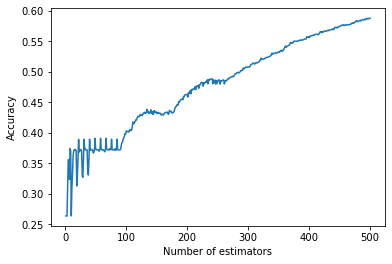

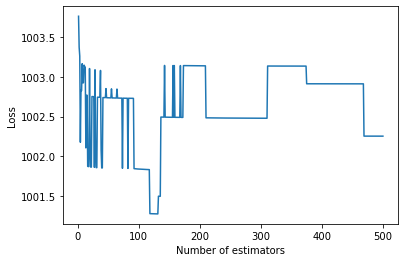

Train accuracy: 58.71% over 500 trees
Test accuracy: 59.63% over 500 trees


In [6]:
from functions import *
n_estimators = 500
booster_update2 = Boost(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=2)).update_fit(Xtrain,Ytrain, verbose=1, batch_size=60)
print(f"Train accuracy: {booster_update2.accuracy(booster_update2.predict(Xtrain), Ytrain):.2%} over {n_estimators} trees")
print(f"Test accuracy: {booster_update2.accuracy(booster_update2.predict(Xtest),Ytest):.2%} over {n_estimators} trees")